# May 5, 2022

## Pandas

In [1]:
import pandas as pd

In [2]:
help(pd)

Help on package pandas:

NAME
    pandas

DESCRIPTION
    pandas - a powerful data analysis and manipulation library for Python
    
    **pandas** is a Python package providing fast, flexible, and expressive data
    structures designed to make working with "relational" or "labeled" data both
    easy and intuitive. It aims to be the fundamental high-level building block for
    doing practical, **real world** data analysis in Python. Additionally, it has
    the broader goal of becoming **the most powerful and flexible open source data
    analysis / manipulation tool available in any language**. It is already well on
    its way toward this goal.
    
    Main Features
    -------------
    Here are just a few of the things that pandas does well:
    
      - Easy handling of missing data in floating point as well as non-floating
        point data.
      - Size mutability: columns can be inserted and deleted from DataFrame and
        higher dimensional objects
      - Automatic an

One of the main objects in `pandas` is the `DataFrame`. We can create a dataframe using `pd.DataFrame`:

In [3]:
df = pd.DataFrame()

In [4]:
df

""


We can combine lists to create a dataframe containing their information:

In [6]:
first_names = ['Jonathan','Steven','Emily','Justin']
last_names = ['Lottes','Lottes','Lottes','Lottes']

df = pd.DataFrame(list(zip(first_names,last_names)))

In [7]:
df

,0,1
0,Jonathan,Lottes
1,Steven,Lottes
2,Emily,Lottes
3,Justin,Lottes


We can specify column names when we create the dataframe:

In [8]:
first_names = ['Jonathan','Steven','Emily','Justin']
last_names = ['Lottes','Lottes','Lottes','Lottes']

df = pd.DataFrame(list(zip(first_names,last_names)), 
                  columns = ['First name','Last name'])

In [9]:
df

,First name,Last name
0,Jonathan,Lottes
1,Steven,Lottes
2,Emily,Lottes
3,Justin,Lottes


Every dataframe has an index. If we don't specify an index, then pandas will default to an increasing list of integers starting at 0. We can retrieve the index of a DataFrame using the `.index` attribute:

In [10]:
df.index

RangeIndex(start=0, stop=4, step=1)

We can access the columns of the dataframe according to their labels:

In [11]:
df['First name']

0    Jonathan
1      Steven
2       Emily
3      Justin
Name: First name, dtype: object

If we grab one column of a dataframe, pandas returns a series.

We can add new columns just like with adding elements to a dictionary:

In [12]:
df['City of residence'] = ['Buffalo','Seattle','Pittsburgh','Rochester']

In [17]:
df['Age'] = [32,34,36,38]

In [18]:
df

,First name,Last name,City of residence,Age
0,Jonathan,Lottes,Buffalo,32
1,Steven,Lottes,Seattle,34
2,Emily,Lottes,Pittsburgh,36
3,Justin,Lottes,Rochester,38


We can grab multiple columns using a list of column labels:

In [16]:
df[['First name','City of residence']]

,First name,City of residence
0,Jonathan,Buffalo
1,Steven,Seattle
2,Emily,Pittsburgh
3,Justin,Rochester


Just like with `numpy`, we can perform operations on pandas dataframes. These operations are done element-wise:

In [19]:
df['First name'] + ' ' + df['Last name']

0    Jonathan Lottes
1      Steven Lottes
2       Emily Lottes
3      Justin Lottes
dtype: object

We can also compute Boolean expressions:

In [20]:
df['Age'] > 35

0    False
1    False
2     True
3     True
Name: Age, dtype: bool

The `.loc` attribute can be used to find a sub-dataframe subject to some conditional statement(s):

In [21]:
df.loc[df['Age'] > 35]

,First name,Last name,City of residence,Age
2,Emily,Lottes,Pittsburgh,36
3,Justin,Lottes,Rochester,38


We can define our own index for a dataframe:

In [25]:
my_index = [1906,1589,1662,4532]

df.index = my_index

In [26]:
df

,First name,Last name,City of residence,Age
1906,Jonathan,Lottes,Buffalo,32
1589,Steven,Lottes,Seattle,34
1662,Emily,Lottes,Pittsburgh,36
4532,Justin,Lottes,Rochester,38


We can export a pandas dataframe to an csv (comma separated values) file, or an excel sheet. We can choose our separator for csv files using the `sep` keyword:

In [32]:
df.to_csv('lottes_family.csv',sep=' ')

In [34]:
df.to_excel('lottes_family.xlsx')

We can read in excel sheets and csv files using `pd.read_csv` and `pd.read_excel`:

In [36]:
new_df = pd.read_csv('lottes_family.csv',sep=' ')
new_df

,Unnamed: 0,First name,Last name,City of residence,Age
0,1906,Jonathan,Lottes,Buffalo,32
1,1589,Steven,Lottes,Seattle,34
2,1662,Emily,Lottes,Pittsburgh,36
3,4532,Justin,Lottes,Rochester,38


We can also read these files directly from the internet:

In [39]:
url = 'https://jllottes.github.io/_downloads/82d80288a3d04c1d3fd267fda24ba301/NYSE_2016_03_25.csv'

NYSE = pd.read_csv(url,
                   skiprows=3)

In [40]:
NYSE

,Name,Symbol,Open,High,Low,Close,Net Chg,% Chg,Volume,52 Wk High,52 Wk Low,YTD % Chg
0,3D Systems,DDD,14.14,14.81,13.60,14.76,0.32,2.22,3240444,32.88,6.00,69.85
1,3M,MMM,163.68,164.54,163.05,164.46,0.19,0.12,1730167,167.70,134.00,9.17
2,58.com ADR,WUBA,56.25,56.76,55.28,56.48,-0.04,-0.07,518280,83.71,37.72,-14.37
3,500.com ADR,WBAI,16.46,17.18,16.04,16.88,0.26,1.56,378620,30.67,9.89,-16.02
4,A10 Networks,ATEN,5.85,5.91,5.77,5.87,-0.03,-0.51,126272,8.30,4.12,-10.52
...,...,...,...,...,...,...,...,...,...,...,...,...
2137,Zendesk,ZEN,19.50,19.60,18.98,19.52,-0.12,-0.61,595860,27.54,14.38,-26.17
2138,Zhaopin ADR,ZPIN,15.85,16.00,15.59,15.78,-0.09,-0.57,93009,17.66,11.65,3.00
2139,Zimmer Biomet Holdings,ZBH,103.58,104.31,103.07,103.74,-0.69,-0.66,850675,119.10,88.27,1.12
2140,Zoe's Kitchen,ZOES,37.65,39.00,37.09,38.48,0.71,1.88,154304,46.61,23.17,37.53


We can take a look at the columns using the `.columns` attribute:

In [42]:
NYSE.loc[NYSE['Net Chg'] > 0]

,Name,Symbol,Open,High,Low,Close,Net Chg,% Chg,Volume,52 Wk High,52 Wk Low,YTD % Chg
0,3D Systems,DDD,14.14,14.81,13.60,14.76,0.32,2.22,3240444,32.88,6.00,69.85
1,3M,MMM,163.68,164.54,163.05,164.46,0.19,0.12,1730167,167.70,134.00,9.17
3,500.com ADR,WBAI,16.46,17.18,16.04,16.88,0.26,1.56,378620,30.67,9.89,-16.02
5,AAC Holdings,AAC,18.18,18.48,17.99,18.38,0.17,0.93,123794,46.60,14.36,-3.57
11,Abercrombie&Fitch,ANF,30.74,31.54,30.58,31.41,0.58,1.88,1496086,32.83,15.42,16.33
...,...,...,...,...,...,...,...,...,...,...,...,...
2130,Yirendai ADR,YRD,8.78,9.80,8.62,9.59,0.43,4.69,415445,10.39,3.35,1.48
2131,Youku Tudou ADR,YOKU,27.48,27.48,27.47,27.48,0.01,0.04,667327,31.50,11.85,1.29
2132,YPF ADR,YPF,17.42,18.10,17.20,18.01,0.22,1.24,554409,32.00,12.67,14.57
2135,ZAIS Financial,ZFC,15.20,15.36,15.01,15.27,0.17,1.13,78959,19.00,12.63,1.26


We can sort a dataframe by its values using the `.sort_values` method:

In [47]:
NYSE.sort_values(by='% Chg',ascending=False)

,Name,Symbol,Open,High,Low,Close,Net Chg,% Chg,Volume,52 Wk High,52 Wk Low,YTD % Chg
858,General Steel Holdings,GSI,2.26,2.88,1.82,1.90,0.58,43.94,7483471,5.20,0.53,42.86
269,BlueLinx Holdings,BXC,0.45,0.59,0.45,0.55,0.10,22.20,153561,1.28,0.30,3.77
103,American Realty Investors,ARL,4.45,5.09,4.45,5.09,0.82,19.20,5579,7.49,3.89,-9.41
1404,NQ Mobile ADR,NQ,4.52,4.94,4.36,4.88,0.53,12.18,2902636,6.54,2.72,34.07
564,Cypress Energy Partners,CELP,7.69,9.11,7.64,8.86,0.95,12.01,59478,18.00,5.28,0.68
...,...,...,...,...,...,...,...,...,...,...,...,...
1755,STAG Industrial,STAG,19.32,19.47,19.01,19.39,NaN,NaN,343442,24.09,14.97,5.09
1761,Startek,SRT,4.16,4.34,4.16,4.30,NaN,NaN,3105,8.51,2.86,20.11
1821,Taomee Holdings ADR,TAOM,3.63,3.64,3.63,3.64,NaN,NaN,2048,4.00,2.15,1.11
1890,Toll Brothers,TOL,28.59,28.68,28.16,28.53,NaN,NaN,1550221,42.19,23.75,-14.32


By default, sorting does not affect the original dataframe. We can either add the optional argument `inplace=True` or overwrite the unsorted dataframe with the sorted one.

In [49]:
NYSE = NYSE.sort_values(by='% Chg')
NYSE

,Name,Symbol,Open,High,Low,Close,Net Chg,% Chg,Volume,52 Wk High,52 Wk Low,YTD % Chg
649,Eastman Kodak WT,KODK%A,2.00,2.00,1.85,1.86,-0.34,-15.45,700,5.75,0.27,1.64
1500,PetroQuest Energy,PQ,0.60,0.61,0.53,0.53,-0.08,-13.11,157126,2.74,0.31,6.00
124,Antero Midstream Partners,AM,21.71,21.94,21.50,21.76,-3.21,-12.86,6337517,29.76,16.47,-4.65
1002,HudBay Minerals WT,HBM%,0.24,0.25,0.24,0.24,-0.03,-10.88,341,1.73,0.08,0.29
1147,Lannett,LCI,18.43,18.69,17.08,18.31,-2.05,-10.07,3838403,72.44,17.08,-54.36
...,...,...,...,...,...,...,...,...,...,...,...,...
1755,STAG Industrial,STAG,19.32,19.47,19.01,19.39,NaN,NaN,343442,24.09,14.97,5.09
1761,Startek,SRT,4.16,4.34,4.16,4.30,NaN,NaN,3105,8.51,2.86,20.11
1821,Taomee Holdings ADR,TAOM,3.63,3.64,3.63,3.64,NaN,NaN,2048,4.00,2.15,1.11
1890,Toll Brothers,TOL,28.59,28.68,28.16,28.53,NaN,NaN,1550221,42.19,23.75,-14.32


In [50]:
NYSE.sort_values('High',inplace=True)
NYSE

,Name,Symbol,Open,High,Low,Close,Net Chg,% Chg,Volume,52 Wk High,52 Wk Low,YTD % Chg
1118,Kinder Morgan WT,KMI%,0.06,0.06,0.05,0.06,0.00,-3.30,127351,5.40,0.03,-7.49
444,Citigroup Wt 2019,C%A,0.09,0.10,0.08,0.09,-0.01,-10.00,78255,0.86,0.06,-50.00
218,Bank of America Cl B WT,BAC%B,0.20,0.20,0.19,0.20,0.01,5.26,5562,0.59,0.15,-25.93
34,Aeropostale,ARO,0.21,0.22,0.20,0.21,0.01,4.17,2237011,3.64,0.16,-25.00
1002,HudBay Minerals WT,HBM%,0.24,0.25,0.24,0.24,-0.03,-10.88,341,1.73,0.08,0.29
...,...,...,...,...,...,...,...,...,...,...,...,...
2085,White Mountains Insurance Group,WTM,767.51,786.99,747.20,781.01,3.96,0.51,13227,808.00,635.00,7.46
184,AutoZone,AZO,803.48,810.00,798.50,803.06,-2.23,-0.28,242923,810.00,652.19,8.24
1220,Markel,MKL,882.02,891.99,867.45,878.80,-6.37,-0.72,77514,937.91,736.96,-0.52
1413,NVR,NVR,1730.89,1742.01,1710.27,1726.00,-3.11,-0.18,11852,1758.93,1292.11,5.05


## Project 9

**Exercise 1.** Write a function `fd` that for a (positive or negative) number returns the integer which is the first non-zero digit of that number. If there are no non-zero digits the function should return 0.

**Exercise 2.** Write a function `ld` that for a (positive or negative) number returns the integer which is the last non-zero digit of that number. If there are no non-zero digits the function should return 0.

In [52]:
office = ['123 Fake Street','Springfield','United States']

print('\n'.join(office))

123 Fake Street
Springfield
United States


In [ ]:
phone_pattern = '\({,1}\d{3}\){,1}[\s-]\d{3}-\d{4}'

In [53]:
import requests

In [54]:
session = requests.Session()

In [ ]:
#requests.get(...)
session.get(...)

# May 4, 2022

In [1]:
import pandas as pd

In [4]:
#country_areas = pd.read_csv('https://jllottes.github.io/_downloads/0f06d32b6f3a7250f190cd627087c8b5/country_areas.csv')
country_areas = pd.read_csv('country_areas.csv', skiprows=2)

In [5]:
country_areas

,Country Name,Country Code,Area (sq km),Area (sq miles)
0,Afghanistan,AFG,652860.0,252071
1,Albania,ALB,28750.0,11100
2,Algeria,DZA,2381740.0,919595
3,American Samoa,ASM,200.0,77
4,Andorra,AND,470.0,182
...,...,...,...,...
205,Virgin Islands (U.S.),VIR,350.0,135
206,West Bank and Gaza,PSE,6020.0,2324
207,Yemen,YEM,527970.0,203850
208,Zambia,ZMB,752610.0,290584


In [6]:
country_populations = pd.read_csv('country_populations.csv')

In [7]:
country_populations

,Country Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,Afghanistan,AFG,8994793.0,9164945.0,9343772.0,9531555.0,9728645.0,9935358.0,10148841.0,10368600.0,...,24399948,25183615,25877544,26528741,27207291,27962207,28809167,29726803,30682500,31627506
1,Albania,ALB,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,1914573.0,1965598.0,...,3011487,2992547,2970017,2947314,2927519,2913021,2904780,2900489,2897366,2894475
2,Algeria,DZA,11124892.0,11404859.0,11690152.0,11985130.0,12295973.0,12626953.0,12980269.0,13354197.0,...,33267887,33749328,34261971,34811059,35401790,36036159,36717132,37439427,38186135,38934334
3,American Samoa,ASM,20012.0,20478.0,21118.0,21883.0,22701.0,23518.0,24320.0,25116.0,...,59117,58648,57904,57031,56226,55636,55316,55227,55302,55434
4,Andorra,AND,13414.0,14376.0,15376.0,16410.0,17470.0,18551.0,19646.0,20755.0,...,81223,83373,84878,85616,85474,84419,82326,79316,75902,72786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,Vietnam,VNM,34743000.0,35428000.0,36123000.0,36836000.0,37574000.0,38341000.0,39142000.0,39980000.0,...,82392100,83311200,84218500,85118700,86025000,86932500,87840000,88772900,89708900,90730000
207,Virgin Islands (U.S.),VIR,32000.0,34100.0,36300.0,38700.0,41300.0,44000.0,47300.0,50800.0,...,107863,107700,107423,107091,106707,106267,105784,105275,104737,104170
208,"Yemen, Rep.",YEM,5166311.0,5251663.0,5339285.0,5429501.0,5522690.0,5619170.0,5720538.0,5827223.0,...,20504385,21093973,21701105,22322699,22954226,23591972,24234940,24882792,25533217,26183676
209,Zambia,ZMB,3049586.0,3142848.0,3240664.0,3342894.0,3449266.0,3559687.0,3674088.0,3792864.0,...,12043591,12381509,12738676,13114579,13507849,13917439,14343526,14786581,15246086,15721343


Let's suppose we want to look at population densities. We'll the area data from the `country_areas` dataframe along with the population data from the `country_populations` dataframe.

We'll use the `.merge` method.

In [19]:
country_data = country_populations.merge(country_areas,
                                         on=['Country Name','Country Code'],
                                         how='inner')
country_data

,Country Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2007,2008,2009,2010,2011,2012,2013,2014,Area (sq km),Area (sq miles)
0,Afghanistan,AFG,8994793.0,9164945.0,9343772.0,9531555.0,9728645.0,9935358.0,10148841.0,10368600.0,...,25877544,26528741,27207291,27962207,28809167,29726803,30682500,31627506,652860.0,252071
1,Albania,ALB,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,1914573.0,1965598.0,...,2970017,2947314,2927519,2913021,2904780,2900489,2897366,2894475,28750.0,11100
2,Algeria,DZA,11124892.0,11404859.0,11690152.0,11985130.0,12295973.0,12626953.0,12980269.0,13354197.0,...,34261971,34811059,35401790,36036159,36717132,37439427,38186135,38934334,2381740.0,919595
3,American Samoa,ASM,20012.0,20478.0,21118.0,21883.0,22701.0,23518.0,24320.0,25116.0,...,57904,57031,56226,55636,55316,55227,55302,55434,200.0,77
4,Andorra,AND,13414.0,14376.0,15376.0,16410.0,17470.0,18551.0,19646.0,20755.0,...,84878,85616,85474,84419,82326,79316,75902,72786,470.0,182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,Vanuatu,VUT,63701.0,65708.0,67806.0,69962.0,72131.0,74287.0,76410.0,78518.0,...,219956,225335,230782,236299,241876,247498,253165,258883,12190.0,4707
192,Vietnam,VNM,34743000.0,35428000.0,36123000.0,36836000.0,37574000.0,38341000.0,39142000.0,39980000.0,...,84218500,85118700,86025000,86932500,87840000,88772900,89708900,90730000,330972.0,127789
193,Virgin Islands (U.S.),VIR,32000.0,34100.0,36300.0,38700.0,41300.0,44000.0,47300.0,50800.0,...,107423,107091,106707,106267,105784,105275,104737,104170,350.0,135
194,Zambia,ZMB,3049586.0,3142848.0,3240664.0,3342894.0,3449266.0,3559687.0,3674088.0,3792864.0,...,12738676,13114579,13507849,13917439,14343526,14786581,15246086,15721343,752610.0,290584


Here, the merged dataframe contains 196 rows. The `country_areas` has 210 rows, while the `country_populations` has 211 rows. By default, the merged dataframe will only contain rows that exist in both dataframes.

In [18]:
country_data.to_csv('country_data.csv')

Let's create a new dataframe, for now consisting only of the country and country code.

In [21]:
country_densities = pd.DataFrame(country_data[['Country Name','Country Code']])

We'll then iterate through the population columns in `country_data` to compute the country population density, and store the result in `country_densities`:

In [23]:
year_columns = country_data.columns[2:-2]
year_columns

Index(['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014'],
      dtype='object')

In [24]:
for year_column in year_columns:
    country_densities[year_column] = country_data[year_column] / country_data['Area (sq miles)']

In [29]:
country_densities[['Country Name','2014']].sort_values(by='2014',ascending=False)

,Country Name,2014
116,Monaco,37623.000000
155,Singapore,19746.209386
13,Bahrain,4585.622896
108,Maldives,3456.896552
110,Malta,3446.806452
...,...,...
79,Iceland,8.237295
10,Australia,7.859322
122,Namibia,7.549984
117,Mongolia,4.818385


In [31]:
list(str(7.123))

['7', '.', '1', '2', '3']

In [37]:
for n in list(str(-7.0123)):
    if not n in '0.-':
        print(n)

7
1
2
3


**Note.** The `airports.csv` file requires a special encoding to properly read. We can use `Latin` to read it:

In [41]:
airports_df = pd.read_csv('airports.csv',encoding='Latin',skiprows=2)

In [42]:
airports_df

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NaN,US,US-PA,Bensalem,no,00A,NaN,00A
1,6524,00AK,small_airport,Lowell Field,59.949200,-151.695999,450.0,NaN,US,US-AK,Anchor Point,no,00AK,NaN,00AK
2,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,00AL,NaN,00AL
3,6526,00AR,heliport,Newport Hospital & Clinic Heliport,35.608700,-91.254898,237.0,NaN,US,US-AR,Newport,no,00AR,NaN,00AR
4,6527,00AZ,small_airport,Cordes Airport,34.305599,-112.165001,3810.0,NaN,US,US-AZ,Cordes,no,00AZ,NaN,00AZ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47531,27244,ZYYJ,medium_airport,Yanji Chaoyangchuan Airport,42.882801,129.451004,624.0,AS,CN,CN-22,Yanji,yes,ZYYJ,YNJ,NaN
47532,32753,ZYYY,medium_airport,Shenyang Dongta Airport,41.784401,123.496002,NaN,AS,CN,CN-21,Shenyang,no,ZYYY,NaN,NaN
47533,46378,ZZ-0001,heliport,Sealand Helipad,51.894444,1.482500,40.0,EU,GB,GB-ENG,Sealand,no,NaN,NaN,NaN
47534,307326,ZZ-0002,small_airport,Glorioso Islands Airstrip,-11.584278,47.296389,11.0,AF,TF,TF-U-A,Grande Glorieuse,no,NaN,NaN,NaN


We can apply functions to values in a dataframe using the `.apply` method:

In [43]:
def classify_height(x):
    if x < 1000:
        return 'Low elevation'
    elif x < 3000:
        return 'Medium elevation'
    else: 
        return 'High elevation'

In [46]:
airports_df['Height classification'] = airports_df['elevation_ft'].apply(classify_height)

In [47]:
airports_df

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,Height classification
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NaN,US,US-PA,Bensalem,no,00A,NaN,00A,Low elevation
1,6524,00AK,small_airport,Lowell Field,59.949200,-151.695999,450.0,NaN,US,US-AK,Anchor Point,no,00AK,NaN,00AK,Low elevation
2,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,00AL,NaN,00AL,Low elevation
3,6526,00AR,heliport,Newport Hospital & Clinic Heliport,35.608700,-91.254898,237.0,NaN,US,US-AR,Newport,no,00AR,NaN,00AR,Low elevation
4,6527,00AZ,small_airport,Cordes Airport,34.305599,-112.165001,3810.0,NaN,US,US-AZ,Cordes,no,00AZ,NaN,00AZ,High elevation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47531,27244,ZYYJ,medium_airport,Yanji Chaoyangchuan Airport,42.882801,129.451004,624.0,AS,CN,CN-22,Yanji,yes,ZYYJ,YNJ,NaN,Low elevation
47532,32753,ZYYY,medium_airport,Shenyang Dongta Airport,41.784401,123.496002,NaN,AS,CN,CN-21,Shenyang,no,ZYYY,NaN,NaN,High elevation
47533,46378,ZZ-0001,heliport,Sealand Helipad,51.894444,1.482500,40.0,EU,GB,GB-ENG,Sealand,no,NaN,NaN,NaN,Low elevation
47534,307326,ZZ-0002,small_airport,Glorioso Islands Airstrip,-11.584278,47.296389,11.0,AF,TF,TF-U-A,Grande Glorieuse,no,NaN,NaN,NaN,Low elevation


In [49]:
airports_df.loc[airports_df['Height classification'] == 'Low elevation']

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,Height classification
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NaN,US,US-PA,Bensalem,no,00A,NaN,00A,Low elevation
1,6524,00AK,small_airport,Lowell Field,59.949200,-151.695999,450.0,NaN,US,US-AK,Anchor Point,no,00AK,NaN,00AK,Low elevation
2,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,00AL,NaN,00AL,Low elevation
3,6526,00AR,heliport,Newport Hospital & Clinic Heliport,35.608700,-91.254898,237.0,NaN,US,US-AR,Newport,no,00AR,NaN,00AR,Low elevation
7,6531,00FA,small_airport,Grass Patch Airport,28.645500,-82.219002,53.0,NaN,US,US-FL,Bushnell,no,00FA,NaN,00FA,Low elevation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47530,27243,ZYTX,large_airport,Taoxian Airport,41.639801,123.483002,198.0,AS,CN,CN-21,Shenyang,yes,ZYTX,SHE,NaN,Low elevation
47531,27244,ZYYJ,medium_airport,Yanji Chaoyangchuan Airport,42.882801,129.451004,624.0,AS,CN,CN-22,Yanji,yes,ZYYJ,YNJ,NaN,Low elevation
47533,46378,ZZ-0001,heliport,Sealand Helipad,51.894444,1.482500,40.0,EU,GB,GB-ENG,Sealand,no,NaN,NaN,NaN,Low elevation
47534,307326,ZZ-0002,small_airport,Glorioso Islands Airstrip,-11.584278,47.296389,11.0,AF,TF,TF-U-A,Grande Glorieuse,no,NaN,NaN,NaN,Low elevation


We can count the number of rows for each value using the `.value_counts()` method:

In [52]:
counts = airports_df['Height classification'].value_counts()
counts

Low elevation       27482
Medium elevation    11453
High elevation       8601
Name: Height classification, dtype: int64

We can easily generate plots with pandas:

In [51]:
import matplotlib.pyplot as plt

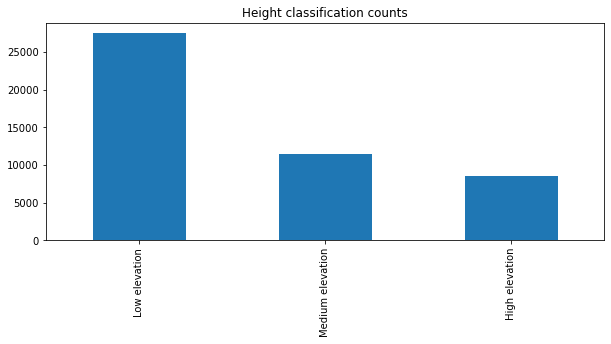

In [55]:
plt.figure(figsize=(10,4))
counts.plot(kind='bar')
plt.title('Height classification counts')
plt.show()